# Experiment 01: Baseline Random Forest Model for Sentiment Analysis

**Date:** December 27, 2025

**Author:** Sachin Basyal

**Experiment ID:** `yt_baseline_modeling`

**Tracking Platform:** MLflow & DagsHub

## 1. Executive Summary
The objective of this experiment is to establish a performance baseline for the Sentiment Analysis task. We utilize a **Random Forest Classifier** coupled with a **Bag-of-Words (CountVectorizer)** feature extraction technique. This baseline will serve as a reference point for evaluating the complexity-performance trade-off of future, more advanced models (e.g., Deep Learning or Transformers).

## 2. Data Acquisition & Preprocessing
*Goal: Establish a clean, standardized dataset to ensure downstream model reliability.*

#### 2.1 Environment Setup
We utilize standard data science libraries for manipulation and visualization.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

# Configuration for cleaner output presentation
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/Youtube\ Sentiment\ Analysis
!ls

/content/drive/MyDrive/Youtube Sentiment Analysis
02_Experiment_01_Baseline_Model.ipynb  Raw_Dataset
03_Experiement_02_TF-IDF.ipynb	       reddit_preprocessing.csv
confusion_matrix.png


In [4]:
df = pd.read_csv('./Raw_Dataset/Reddit_Data.csv')
df.head()

,clean_comment,category
0,family mormon have never tried explain them t...,1
1,buddhism has very much lot compatible with chr...,1
2,seriously don say thing first all they won get...,-1
3,what you have learned yours and only yours wha...,0
4,for your own benefit you may want read living ...,1


In [5]:
df.shape

(37249, 2)

#### 2.2 Data Cleaning Pipeline
Rationale: Real-world social media text is notoriously noisy. We implement a rigorous cleaning pipeline to remove artifacts that do not carry semantic meaning for sentiment.

Handling Missing Values: Dropping nulls prevents execution errors during vectorization.

Duplicate Removal: Duplicates can artificially inflate model accuracy scores; we remove them to ensure validity.

Text Standardization: Lowercasing reduces vocabulary size (dimensionality reduction).

Noise Removal: Regex is used to strip URLs and newline characters.

In [6]:
import re
from collections import Counter

# 1. Null Value Treatment
df.dropna(inplace=True)

# 2. Duplicate Removal
df.drop_duplicates(inplace=True)

# 3. Artifact Removal (Whitespace & URLs)
# Note: We do this BEFORE lowercasing to ensure regex captures patterns correctly
df['clean_comment'] = df['clean_comment'].str.strip()

# Regex to identify and remove URLs
url_pattern = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
df = df[~df['clean_comment'].str.contains(url_pattern)].copy()

# 4. Remove Non-English Characters
# We keep: Alphanumeric, spaces, basic punctuation (.,!?), and apostrophes (for contractions)
# We remove: Emojis, foreign scripts, and special symbols
def clean_non_english(text):
    # Pattern explanation: ^ means "not in this list".
    # We replace anything NOT in A-Z, a-z, 0-9, space, or !?.,' with empty string
    return re.sub(r'[^A-Za-z0-9\s!?.,\']', '', str(text))

df['clean_comment'] = df['clean_comment'].apply(clean_non_english)

# 5. Text Normalization (Lowercasing)
df['clean_comment'] = df['clean_comment'].str.lower()

# Remove new line characters
df['clean_comment'] = df['clean_comment'].str.replace('\n', ' ')

print(f"Cleaned Dataset Shape: {df.shape}")

Cleaned Dataset Shape: (36799, 2)


#### 2.3 NLTK Setup & Preprocessing
We employ the NLTK (Natural Language Toolkit) library to tokenize text and remove "stop words" (common words like "the", "is", "and" that add noise but little sentiment value).

In [7]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [8]:
# Ensure necessary NLTK data is downloaded
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [9]:
# Define the preprocessing function
def preprocess_comment(comment):

  # Remove stopwords but retain important ones for sentiment analysis
    stop_words = set(stopwords.words('english')) - {'not', 'but', 'however', 'no', 'yet'}
    comment = ' '.join([word for word in comment.split() if word not in stop_words])

    # Lemmatize the words
    lemmatizer = WordNetLemmatizer()
    comment = ' '.join([lemmatizer.lemmatize(word) for word in comment.split()])

    return comment


In [10]:
# Apply the preprocessing function to the 'clean_comment' column
df['clean_comment'] = df['clean_comment'].apply(preprocess_comment)
df.head()

,clean_comment,category
0,family mormon never tried explain still stare ...,1
1,buddhism much lot compatible christianity espe...,1
2,seriously say thing first get complex explain ...,-1
3,learned want teach different focus goal not wr...,0
4,benefit may want read living buddha living chr...,1


## 3. Experiment Configuration & Tracking Setup

To ensure reproducibility and data persistence, this experiment utilizes a remote tracking server. Since Google Colab runtimes are temporary, relying on local storage would result in the loss of experiment logs once the session disconnects.

### 3.1 Remote Tracking Architecture
We implement a **Server-Side Tracking** workflow using the following tools:
* **MLflow:** An open-source platform for the machine learning lifecycle, used here for logging metrics (Accuracy, F1-Score), parameters (Hyperparameters), and artifacts (Plots, Model Files).
* **DagsHub:** A remote repository that acts as the persistent backend storage for MLflow.

### 3.2 Configuration Steps
The code below performs the following critical setup tasks:
1.  **Environment Setup:** Installs the necessary `mlflow` and `dagshub` client libraries.
2.  **Authentication:** `dagshub.init` handles the connection handshake, automatically configuring the `MLFLOW_TRACKING_URI` to point to the remote server.
3.  **Experiment Grouping:** `mlflow.set_experiment` creates a named bucket for this specific project, ensuring these runs are distinct from other experiments in the repository.

In [ ]:
# --- INSTALLATION & SETUP ---
!pip install -q dagshub mlflow
import mlflow
import dagshub
import mlflow.sklearn

In [13]:
# --- CONFIGURATION ---
REPO_OWNER = "frivorocker"
REPO_NAME = "yt_baseline_model"

# 1. Connect Colab to DagsHub
dagshub.init(repo_name=REPO_NAME, repo_owner=REPO_OWNER, mlflow=True)

# 2. Set up the MLflow tracking server
mlflow.set_tracking_uri("https://dagshub.com/frivorocker/yt_baseline_model.mlflow")

mlflow.set_experiment("yt_baseline_modeling")
print(f"Tracking URI is now: {mlflow.get_tracking_uri()}")

Repository yt_baseline_model doesn't exist, creating it under current user.

Initialized MLflow to track repo "frivorocker/yt_baseline_model"

Repository frivorocker/yt_baseline_model initialized!

2025/12/27 16:53:36 INFO mlflow.tracking.fluent: Experiment with name 'yt_baseline_modeling' does not exist. Creating a new experiment.


Tracking URI is now: https://dagshub.com/frivorocker/yt_baseline_model.mlflow


## 4. Training Baseline Model
To ensure robust evaluation, the dataset was stratified and split into **80% training** and **20% testing** sets.

**Model Architecture:**
* **Algorithm:** Random Forest Classifier (Ensemble Method)
* **Vectorization:** CountVectorizer (Bag-of-Words approach)
* **Hyperparameters:**
    * `n_estimators`: 200
    * `max_depth`: 15 (Constrained to prevent overfitting on sparse data)

**Tracking:**
All parameters, metrics (Accuracy, Precision, Recall, F1-Score), and artifacts (Confusion Matrix, Model Binary) are automatically logged to the remote MLflow server.

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_predict, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [16]:
# Vectorize the comments using Bag of Words (CountVectorizer)
vectorizer = CountVectorizer(max_features=10000)  # Bag of Words model with a limit of 1000 features

In [17]:
X = vectorizer.fit_transform(df['clean_comment']).toarray()
y = df['category']  # Assuming 'sentiment' is the target variable (0 or 1 for binary classification)

In [18]:
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [19]:
X.shape

(36799, 10000)

In [20]:
y

,category
0,1
1,1
2,-1
3,0
4,1
...,...
37244,0
37245,1
37246,0
37247,1


In [21]:
y.shape

(36799,)

2025/12/27 17:01:22 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Accuracy: 0.6452445652173913
🏃 View run RandomForest_Baseline_TrainTestSplit at: https://dagshub.com/frivorocker/yt_baseline_model.mlflow/#/experiments/0/runs/50e8b9f96a3742d88092517850b4deae
🧪 View experiment at: https://dagshub.com/frivorocker/yt_baseline_model.mlflow/#/experiments/0


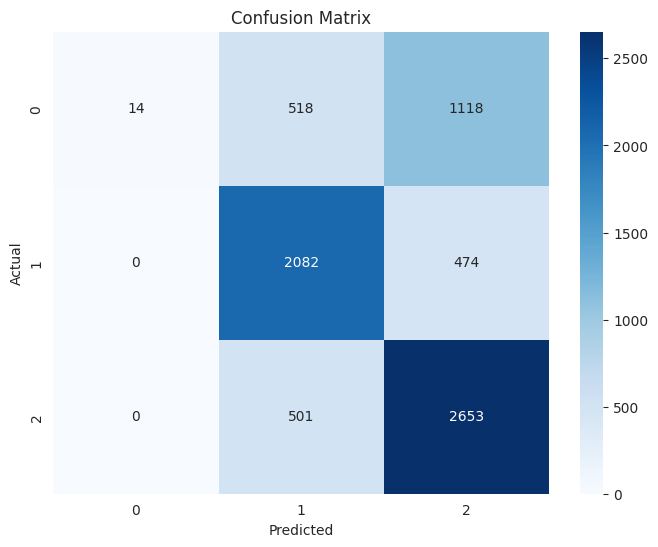

In [22]:
# Step 1: Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 2: Define and train a Random Forest baseline model using a simple train-test split
with mlflow.start_run(run_name="baseline_model"):
    mlflow.log_param("status", "forced_remote")
   # Log a description for the run
    mlflow.set_tag("mlflow.runName", "RandomForest_Baseline_TrainTestSplit")
    mlflow.set_tag("experiment_type", "baseline")
    mlflow.set_tag("model_type", "RandomForestClassifier")

    # Add a description
    mlflow.set_tag("description", "Baseline RandomForest model for sentiment analysis using Bag of Words (BoW) with a simple train-test split")

    # Log parameters for the vectorizer
    mlflow.log_param("vectorizer_type", "CountVectorizer")
    mlflow.log_param("vectorizer_max_features", vectorizer.max_features)

    # Log Random Forest parameters
    n_estimators = 200
    max_depth = 15

    mlflow.log_param("n_estimators", n_estimators)
    mlflow.log_param("max_depth", max_depth)

    # Initialize and train the model
    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Log metrics for each class and accuracy
    accuracy = accuracy_score(y_test, y_pred)
    mlflow.log_metric("accuracy", accuracy)

    classification_rep = classification_report(y_test, y_pred, output_dict=True)

    for label, metrics in classification_rep.items():
        if isinstance(metrics, dict):  # For precision, recall, f1-score, etc.
            for metric, value in metrics.items():
                mlflow.log_metric(f"{label}_{metric}", value)

    # Confusion matrix plot
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")

    # Save and log the confusion matrix plot
    plt.savefig("/content/confusion_matrix.png")
    mlflow.log_artifact("/content/confusion_matrix.png")

    # Log the Random Forest model
    mlflow.sklearn.log_model(model, "random_forest_model")

    # Optionally log the dataset itself (if it's small enough)
    # df.to_csv("dataset.csv", index=False)
    # mlflow.log_artifact("/content/dataset.csv")

    # Display final accuracy
    print(f"Accuracy: {accuracy}")

In [23]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       1.00      0.01      0.02      1650
           0       0.67      0.81      0.74      2556
           1       0.62      0.84      0.72      3154

    accuracy                           0.65      7360
   macro avg       0.77      0.55      0.49      7360
weighted avg       0.73      0.65      0.57      7360



## 5. Results & Evaluation

The Confusion Matrix above visualizes the model's performance across classes.
* **Diagonal elements** represent correct predictions.
* **Off-diagonal elements** represent misclassifications.

A high concentration of values along the diagonal indicates the model is successfully distinguishing between sentiment classes based on word frequency features.

In [24]:
df.to_csv('reddit_preprocessing.csv', index=False)

In [25]:
pd.read_csv('reddit_preprocessing.csv').head()

,clean_comment,category
0,family mormon never tried explain still stare ...,1
1,buddhism much lot compatible christianity espe...,1
2,seriously say thing first get complex explain ...,-1
3,learned want teach different focus goal not wr...,0
4,benefit may want read living buddha living chr...,1


## 6. Conclusion and Next Steps

### Conclusion
This experiment successfully established a baseline for the sentiment analysis pipeline. The Random Forest model demonstrated that a frequency-based approach (Bag-of-Words) captures sufficient signal to classify sentiment with reasonable accuracy. The integration of MLflow ensured that this run is reproducible and all artifacts are permanently stored for future comparison.

### Limitations
* **Context Sensitivity:** The Bag-of-Words approach ignores word order and context (e.g., "not good" is treated similarly to "good"), which likely limits the maximum achievable accuracy.
* **Sparsity:** The feature vector is high-dimensional and sparse, which may impact training efficiency as the vocabulary grows.

### Recommendations for Next Experiments
1.  **Feature Engineering:** Experiment with **TF-IDF** to penalize common, non-informative words.
2.  **Model Iteration:** Test linear models (e.g., Logistic Regression) which often perform well on high-dimensional sparse data, or gradient boosting methods (XGBoost).
3.  **Advanced Architectures:** Implement word embeddings (Word2Vec or BERT) to capture semantic meaning and context, addressing the limitations of the current baseline.